# Facial Expression Detection

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader , random_split

Now we define Transform Function

In [17]:
trainTransfrom = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

testTransfrom = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [18]:
trainTestPath = "images/train/"
validationPath = "images/validation/"
fullData = ImageFolder(root=trainTestPath, transform=trainTransfrom)
totalSize = len(fullData)
trainSize = int(0.8 * totalSize)
testSize = totalSize - trainSize
trainDataSet, testDataSet = random_split(fullData, [trainSize, testSize])
validationDataSet = ImageFolder(root=validationPath, transform=testTransfrom)

In [19]:
trainDataLoader = DataLoader(trainDataSet , batch_size=64 , shuffle=True)
validationDataLoader = DataLoader(validationDataSet , batch_size=64 , shuffle=True)
testDataLoader = DataLoader(testDataSet , batch_size=64 , shuffle=True)

In [20]:
classes = [ 'happy' , 'neutral' , 'sad']
classes

['happy', 'neutral', 'sad']

In [21]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [22]:
images , labels = next(iter(trainDataLoader))
images = images.numpy()
images.shape

(64, 3, 48, 48)

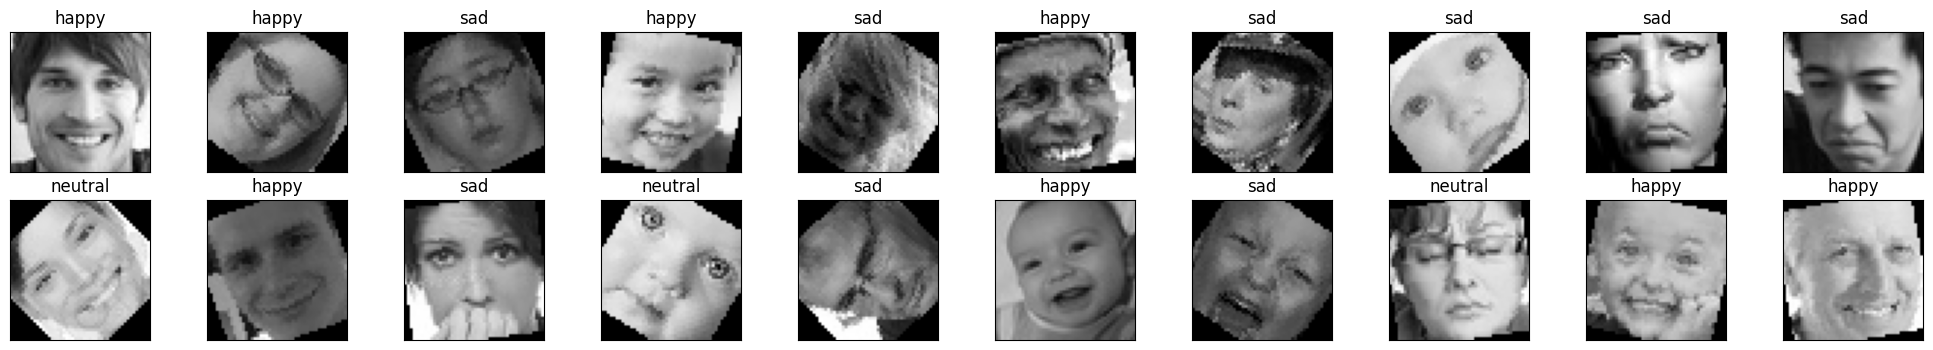

In [23]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [24]:
print(len(trainDataLoader))
print(len(testDataLoader))
print(len(validationDataLoader))

265
67
82


In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)


        self.pool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(
            4608, 512
        )  # Adjusted the input size based on the flattened tensor size
        self.batchnorm5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 128)
        self.batchnorm6 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))

        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))


        x = self.flatten(x)

        x = F.relu(self.batchnorm5(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batchnorm6(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [26]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (batchnorm5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (batchnorm6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [27]:
if torch.cuda.is_available:
    model.cuda()

In [28]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters() , lr=0.003)

In [29]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainDataLoader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in validationDataLoader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainDataLoader.sampler)
    valid_loss = valid_loss/len(validationDataLoader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.004272 	Validation Loss: 0.851175
Validation loss decreased (inf --> 0.851175).  Saving model ...
Epoch: 2 	Training Loss: 0.853718 	Validation Loss: 0.925632
Epoch: 3 	Training Loss: 0.791720 	Validation Loss: 0.805591
Validation loss decreased (0.851175 --> 0.805591).  Saving model ...
Epoch: 4 	Training Loss: 0.751110 	Validation Loss: 0.708280
Validation loss decreased (0.805591 --> 0.708280).  Saving model ...
Epoch: 5 	Training Loss: 0.718250 	Validation Loss: 0.721340
Epoch: 6 	Training Loss: 0.697380 	Validation Loss: 0.672487
Validation loss decreased (0.708280 --> 0.672487).  Saving model ...
Epoch: 7 	Training Loss: 0.679998 	Validation Loss: 0.656600
Validation loss decreased (0.672487 --> 0.656600).  Saving model ...
Epoch: 8 	Training Loss: 0.660347 	Validation Loss: 0.620100
Validation loss decreased (0.656600 --> 0.620100).  Saving model ...
Epoch: 9 	Training Loss: 0.642519 	Validation Loss: 0.628244
Epoch: 10 	Training Loss: 0.632341 	Valida

In [30]:
# track test loss

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in testDataLoader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i, label in enumerate(target):
        class_correct[label] += correct[i].item()
        class_total[label] += 1


# average test loss
test_loss = test_loss/len(testDataLoader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.618699

Test Accuracy of happy: 82% (1149/1395)
Test Accuracy of neutral: 55% (556/1003)
Test Accuracy of   sad: 77% (1428/1840)

Test Accuracy (Overall): 73% (3133/4238)
